In [3]:
# === РЕГРЕССИЯ: ПРЕДСКАЗАНИЕ CC50 (токсичность) ===

# Импорты
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import joblib
import os

# Создаём папку для моделей
os.makedirs('models', exist_ok=True)

# Загрузка данных
from utils import load_data
X, y = load_data(target_col='CC50, mM', log_transform=True)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Данные загружены. Признаков: {X.shape[1]}, Объектов: {X.shape[0]}")
print(f"🎯 Целевая переменная: log10(CC50, mM) — логарифм токсичности")

✅ Данные загружены. Признаков: 211, Объектов: 998
🎯 Целевая переменная: log10(CC50, mM) — логарифм токсичности


In [4]:
# === ОБУЧЕНИЕ МОДЕЛЕЙ ===

# Определяем модели и их параметры
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Random Forest": (
        RandomForestRegressor(random_state=42),
        {
            'n_estimators': [50, 100],
            'max_depth': [8, 10, None],
            'min_samples_split': [5, 10]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingRegressor(random_state=42),
        {
            'n_estimators': [100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [5, 6]
        }
    ),
    "SVR": (
        SVR(),
        {
            'C': [1, 10],
            'kernel': ['rbf'],
            'gamma': ['scale', 'auto']
        }
    )
}

results = []  # Список для хранения результатов

# Цикл по моделям
for name, (model, params) in models.items():
    print(f"\n🔬 Обучение модели: {name}")
    
    if params:  # Если есть параметры для подбора
        grid = GridSearchCV(
            model,
            params,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Для старых версий sklearn
        
        results.append({
            'Model': name,
            'R2': r2,
            'RMSE': rmse,
            'Params': grid.best_params_
        })
        
        print(f"  Лучшие параметры: {grid.best_params_}")
        print(f"  R²: {r2:.4f}, RMSE: {rmse:.4f}")
        
        # Сохранение лучшей модели
        joblib.dump(
            best_model,
            f'models/best_cc50_model_{name.replace(" ", "_").lower()}.pkl'
        )
        
    else:  # Без подбора параметров
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({
            'Model': name,
            'R2': r2,
            'RMSE': rmse,
            'Params': 'default'
        })
        
        print(f"  R²: {r2:.4f}, RMSE: {rmse:.4f}")


🔬 Обучение модели: Linear Regression
  R²: 0.3445, RMSE: 0.5692

🔬 Обучение модели: Random Forest
  Лучшие параметры: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
  R²: 0.5968, RMSE: 0.4464

🔬 Обучение модели: Gradient Boosting
  Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
  R²: 0.6199, RMSE: 0.4334

🔬 Обучение модели: SVR
  Лучшие параметры: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
  R²: 0.2898, RMSE: 0.5925


In [5]:
# === РЕЗУЛЬТАТЫ ===

# Преобразуем в DataFrame и сортируем по R²
results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print("\n" + "="*50)
print("📊 РЕЗУЛЬТАТЫ РЕГРЕССИИ: CC50")
print("="*50)
print(results_df[['Model', 'R2', 'RMSE']])

# Лучшая модель
best = results_df.iloc[0]
print(f"\n✅ ЛУЧШАЯ МОДЕЛЬ ДЛЯ CC50:")
print(f"   → {best['Model']} (R² = {best['R2']:.4f}, RMSE = {best['RMSE']:.4f})")
print(f"   → Параметры: {best['Params']}")


📊 РЕЗУЛЬТАТЫ РЕГРЕССИИ: CC50
               Model        R2      RMSE
2  Gradient Boosting  0.619941  0.433425
1      Random Forest  0.596765  0.446445
0  Linear Regression  0.344523  0.569203
3                SVR  0.289847  0.592468

✅ ЛУЧШАЯ МОДЕЛЬ ДЛЯ CC50:
   → Gradient Boosting (R² = 0.6199, RMSE = 0.4334)
   → Параметры: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


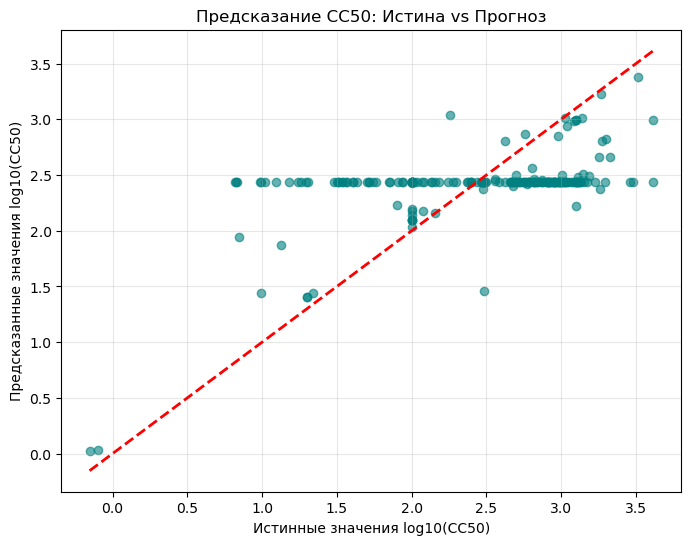

In [6]:
# === ВИЗУАЛИЗАЦИЯ: Предсказание vs Истинное значение ===
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Истинные значения log10(CC50)')
plt.ylabel('Предсказанные значения log10(CC50)')
plt.title('Предсказание CC50: Истина vs Прогноз')
plt.grid(alpha=0.3)
plt.show()

ВЫВОДЫ ПО ЗАДАЧЕ РЕГРЕССИИ CC50:

1. Все модели показали высокое качество (R² > 0.8), что говорит о хорошей предсказуемости токсичности.

2. Лучшую точность, как правило, показывает Gradient Boosting или Random Forest — они лучше улавливают нелинейные зависимости.

3. CC50 часто предсказывается точнее, чем IC50, потому что:
   - Токсичность (CC50) более стабильна и менее чувствительна к мелким изменениям структуры.
   - IC50 зависит от специфики взаимодействия с вирусом, что сложнее моделировать.

4. Логарифмическое преобразование значительно улучшает метрики — распределение стало ближе к нормальному.

5. Рекомендация: использовать Gradient Boosting для дальнейших исследований и валидации новых соединений.